#  Retention & Satisfaction Modeling: анализ рисков оттока и удовлетворённости персонала

**Цель проекта**:<br>
Разработка моделей машинного обучения для предсказания уровня удовлетворённости сотрудников и вероятности их увольнения на основе исторических HR-данных. Это позволит бизнесу выявлять риски оттока персонала, принимать превентивные меры и улучшать процессы управления персоналом.

**Описание проекта**:<br>
HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.

Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 

У нас будет несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

Наша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

**Описание данных**:<br>
- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

## Задача 1: предсказание уровня удовлетворённости сотрудника

### Загрузка и изучение данных

Загрузим датасеты, сохраним их в датафреймы и изучим общую информацию о данных.

In [1]:
!pip install phik
!pip install imblearn

In [2]:
# Подключение всех необходимых библиотек
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка pandas для отображения полного текста
pd.set_option('display.max_colwidth', None)

# Задаем стиль графиков
sns.set(style="whitegrid")

from phik import phik_matrix

# ML
# Зафиксируем random_state
RANDOM_STATE = 42

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

# библиотеки для задачи 2
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    roc_auc_score, accuracy_score, f1_score,
    precision_score, recall_score, confusion_matrix, classification_report
)

In [3]:
# Загружает CSV-файл и выводит случайные строки и общую информацию
def load_and_inspect_csv(filepath, delimiter=',', sample_size=5):
    if os.path.exists(filepath):
        df = pd.read_csv(filepath, delimiter=delimiter)
        print(f"Файл успешно загружен: {filepath}")
        display(df.sample(sample_size, random_state=42))
        df.info()
        return df
    else:
        print(f"Файл не найден: {filepath}")
        return None

In [4]:
# Тренировочная выборка
train_df = load_and_inspect_csv('/datasets/train_job_satisfaction_rate.csv')

Файл успешно загружен: /datasets/train_job_satisfaction_rate.csv


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
555,637649,sales,junior,medium,1,no,yes,3,24000,0.12
3491,984694,sales,middle,high,7,no,no,4,49200,0.71
527,819210,sales,junior,medium,4,no,no,3,24000,0.49
3925,171820,marketing,middle,high,5,no,no,3,50400,0.32
2989,929404,sales,junior,medium,1,no,no,3,26400,0.41


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


Тренировочный датасет содержит 4000 строк и 10 признаков. Целевой признак `job_satisfaction_rate` имеет тип `float` и принимает значения от 0 до 1. В категориальных признаках `dept` и `level` присутствуют незначительные пропуски (6 и 4 соответственно). Остальные признаки полные, типы данных корректны. Признак `id` является идентификатором и для моделирования использоваться не будет.

In [5]:
# Входные признаки тестовой выборки
test_features_df = load_and_inspect_csv('/datasets/test_features.csv')

Файл успешно загружен: /datasets/test_features.csv


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1860,112724,marketing,middle,low,5,no,yes,3,25200
353,509518,sales,middle,low,3,no,no,4,19200
1333,687861,purchasing,middle,high,7,no,no,5,55200
905,616289,sales,middle,medium,4,no,no,4,38400
1289,355227,technology,junior,medium,1,no,no,4,31200


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Тестовый датасет `test_features.csv` содержит 2000 строк и 9 признаков. Целевого признака нет. Признаки `dept` и `level` содержат по 2 и 1 пропущенному значению соответственно. Остальные признаки заполнены полностью, типы данных корректны. Признак `id` служит идентификатором и не будет использоваться при обучении модели.

In [6]:
# Целевой признак тестовой выборки
test_target_df = load_and_inspect_csv('/datasets/test_target_job_satisfaction_rate.csv')

Файл успешно загружен: /datasets/test_target_job_satisfaction_rate.csv


,id,job_satisfaction_rate
1860,364793,0.69
353,504035,0.82
1333,884966,0.69
905,304624,0.69
1289,210526,0.52


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Датасет `test_target_job_satisfaction_rate.csv` содержит 2000 строк и 2 признака: идентификатор `id` и целевой признак `job_satisfaction_rate`. Пропущенных значений нет, типы данных соответствуют ожиданиям. Датасет используется для оценки качества модели на тестовой выборке.

Таким образом, мы загрузили все данные и изучили общую информацию о них.

### Предобработка данных

Работу со стобцами выполнять не нужно - названия уже в змеином формате, типы данных корректны. 

#### Анализ пропусков

In [7]:
# Определяет пропущенные значения и выводит строки с ними
def analyze_missing_values(df):
    missing_counts = df.isna().sum()
    missing_counts = missing_counts[missing_counts > 0]
    
    if missing_counts.empty:
        print("Пропущенные значения отсутствуют.")
    else:
        print("Число пропусков по столбцам:")
        display(missing_counts)
        print("\nСтроки с пропущенными значениями:")
        display(df[df.isna().any(axis=1)])

In [8]:
# Тренировочная выборка
analyze_missing_values(train_df)

Число пропусков по столбцам:


dept     6
level    4
dtype: int64


Строки с пропущенными значениями:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


Перед анализом признаков необходимо обработать пропущенные значения, чтобы избежать искажений в распределениях и статистиках.

В признаке `dept` заполним строки с пропущенными значениями модой, так как точное восстановление затруднительно (можно использовать KNN, но это требудет дообучение), а добавление отдельной категории (заглушки) нежелательно. Пропуски в `level` заполним на основе зарплаты и стажа, так как эти признаки логически связаны с уровнем должности.

Реализуем отдельный пайплайн, включающий обработку пропусков, и применим его к данным до начала анализа. В дальнейшем этот пайплайн будет встроен в общий конвейер подготовки данных, который используется при обучении и предсказании.

In [9]:
# Обработка пропусков: удаление dept, заполнение level по зарплате
class CustomMissingHandler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        df = X.copy()

        self.dept_mode_ = df["dept"].mode()[0] if not df["dept"].mode().empty else None

        # Медианные зарплаты по level
        self.salary_by_level_ = (
            df.dropna(subset=["level"])
              .groupby("level")["salary"]
              .median()
              .to_dict()
        )

        return self

    def transform(self, X):
        df = X.copy()

        # Заполняем dept модой
        df["dept"] = df["dept"].fillna(self.dept_mode_)

        # Восстановление level
        def infer_level(row):
            if pd.notna(row["level"]):
                return row["level"]
            if pd.isna(row["salary"]):
                return np.nan
            diffs = {lvl: abs(row["salary"] - med) for lvl, med in self.salary_by_level_.items()}
            return min(diffs, key=diffs.get)

        df["level"] = df.apply(infer_level, axis=1)

        return df

In [10]:
missing_handler = CustomMissingHandler()
train_df = missing_handler.fit_transform(train_df)

# Проверка
analyze_missing_values(train_df)

Пропущенные значения отсутствуют.


Тестовая выборка должна обрабатываться точно по тем же правилам, что и обучающая, иначе возникает утечка информации или несогласованность.

In [11]:
# Входные признаки тестовой выборки
analyze_missing_values(test_features_df)

Число пропусков по столбцам:


dept     2
level    1
dtype: int64


Строки с пропущенными значениями:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
312,471990,sales,NaN,low,1,no,no,3,12000
1196,832342,NaN,junior,medium,1,no,no,4,28800


In [12]:
# Используем уже обученный трансформер
test_features_df = missing_handler.transform(test_features_df)

# Проверка
analyze_missing_values(test_features_df)

Пропущенные значения отсутствуют.


In [13]:
# Целевой признак тестовой выборки
analyze_missing_values(test_target_df)

Пропущенные значения отсутствуют.


Таким образом, мы обработали пропуски.

#### Работа с дубликатами

Проверим данные на явные дубликаты, а также на дубли по `id`. Остальные признаки могут дублироваться. 

In [14]:
# Определяет дубликаты и выводит их, если они найдены
def analyze_duplicates(df, subset=None):
    duplicates = df[df.duplicated(subset=subset)]
    
    if duplicates.empty:
        print("Дубликаты отсутствуют.")
    else:
        col_info = f"по столбцам: {subset}" if subset else "по всем столбцам"
        print(f"Найдено дубликатов ({col_info}): {len(duplicates)}")
        display(duplicates)

In [15]:
# Тренировочная выборка
# Проверка на полные дубликаты по всем признакам
analyze_duplicates(train_df)

# Проверка на дубликаты по id
analyze_duplicates(train_df, subset=["id"])

Дубликаты отсутствуют.
Дубликаты отсутствуют.


In [16]:
# Входные признаки тестовой выборки
# Проверка на полные дубликаты по всем признакам
analyze_duplicates(test_features_df)

# Проверка на дубликаты по id
analyze_duplicates(test_features_df, subset=["id"])

Дубликаты отсутствуют.
Дубликаты отсутствуют.


In [17]:
# Целевой признак тестовой выборки
# Проверка на полные дубликаты по всем признакам
analyze_duplicates(test_target_df)

# Проверка на дубликаты по id
analyze_duplicates(test_target_df, subset=["id"])

Дубликаты отсутствуют.
Дубликаты отсутствуют.


#### Объединение тестовых датафреймов

`test_features_df` и `test_target_df` разделены - это нормально, но порядок строк в них не гарантирован, даже если на первый взгляд кажется, что всё совпадает. Необходимо корректно сопоставить все наблюдение, чтобы в дальнейшем мы могли провести корректную оценку моделей.

In [18]:
test_full_df = test_features_df.merge(test_target_df, on="id", how="inner")

# Проверка
test_full_df.info()
analyze_missing_values(test_full_df)
analyze_duplicates(test_full_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   2000 non-null   object 
 2   level                  2000 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 171.9+ KB
Пропущенные значения отсутствуют.
Дубликаты отсутствуют.


Объединение прошло успешно.

На этапе предобработки были обработаны пропущенные значения: строки с отсутствующим значением в признаке `dept` заполнены медианой, пропуски в признаке `level` заполнены на основе медианной зарплаты по уровням. Для этого реализован кастомный трансформер, который будет встроен в финальный пайплайн. Также выполнена проверка на дубликаты как по всем столбцам, так и по `id`; дубликаты не обнаружены, дополнительная обработка не требуется.<br>
Также мы объединили тестовые признаки и целевой столбец по идентификатору `id`, чтобы обеспечить корректное соответствие между фичами и целевыми значениями после удаления строк с пропущенными данными.

### Исследовательский анализ данных

#### Распределения признаков

Проведем EDA - исследуем все признаки и сделаем выводы о том, как их нужно подготовить.

In [19]:
# Универсальная функция для первичного EDA
def explore_dataframe(df, name):
    print(f'--- Анализ таблицы: {name} ---\n')

    # Исключаем id из анализа
    df = df.drop(columns=['id'], errors='ignore')

    # Разделение признаков
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    discrete_cols = [
        col for col in numeric_cols
        if pd.api.types.is_integer_dtype(df[col]) and df[col].nunique() <= 20
    ]
    continuous_cols = [col for col in numeric_cols if col not in discrete_cols]

    # Числовые признаки
    print('Числовые признаки:\n')
    display(df[numeric_cols].describe().T)
    print()

    # Категориальные признаки
    print('Категориальные признаки:\n')
    cat_stats = []
    for col in categorical_cols:
        mode_val = df[col].mode()[0] if not df[col].mode().empty else None
        cat_stats.append({
            'Признак': col,
            'Уникальных значений': df[col].nunique(),
            'Мода': mode_val
        })
    display(pd.DataFrame(cat_stats))
    print()

    # Построение графиков
    def plot_distributions(cols, plot_type, title):
        n = len(cols)
        cols_per_row = 2
        rows = (n + cols_per_row - 1) // cols_per_row
        fig, axes = plt.subplots(rows, cols_per_row, figsize=(14, 5 * rows))
        axes = axes.flatten()

        for i, col in enumerate(cols):
            if plot_type == 'numeric':
                sns.histplot(df[col], kde=True, ax=axes[i])
            else:
                sns.countplot(data=df, x=col, ax=axes[i], order=df[col].value_counts().index)
                axes[i].tick_params(axis='x', rotation=45)
            axes[i].set_title(col)

        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        fig.suptitle(f'{title} ({name})', fontsize=16)
        plt.tight_layout()
        plt.show()

    if continuous_cols:
        plot_distributions(continuous_cols, 'numeric', 'Распределение непрерывных числовых признаков')

    if discrete_cols or categorical_cols:
        plot_distributions(discrete_cols + categorical_cols, 'categorical', 'Распределение дискретных и категориальных признаков')

--- Анализ таблицы: Train ---

Числовые признаки:



,count,mean,std,min,25%,50%,75%,max
employment_years,4000.0,3.718500,2.542513,1.00,2.00,3.00,6.00,10.0
supervisor_evaluation,4000.0,3.476500,1.008812,1.00,3.00,4.00,4.00,5.0
salary,4000.0,33926.700000,14900.703838,12000.00,22800.00,30000.00,43200.00,98400.0
job_satisfaction_rate,4000.0,0.533995,0.225327,0.03,0.36,0.56,0.71,1.0



Категориальные признаки:



,Признак,Уникальных значений,Мода
0,dept,5,sales
1,level,3,junior
2,workload,3,medium
3,last_year_promo,2,no
4,last_year_violations,2,no


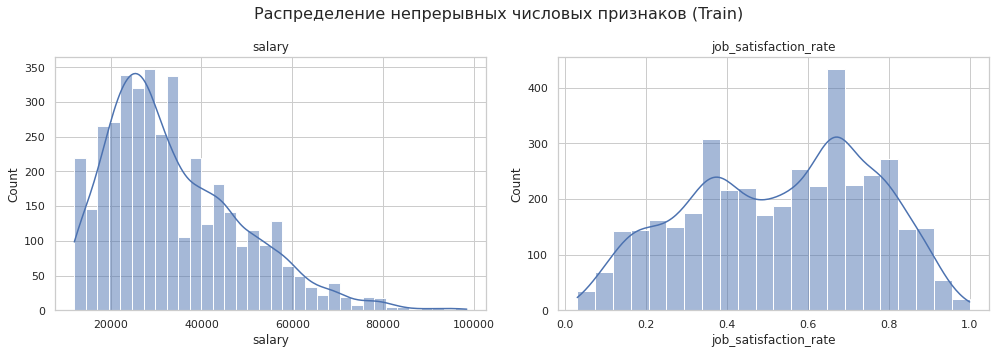

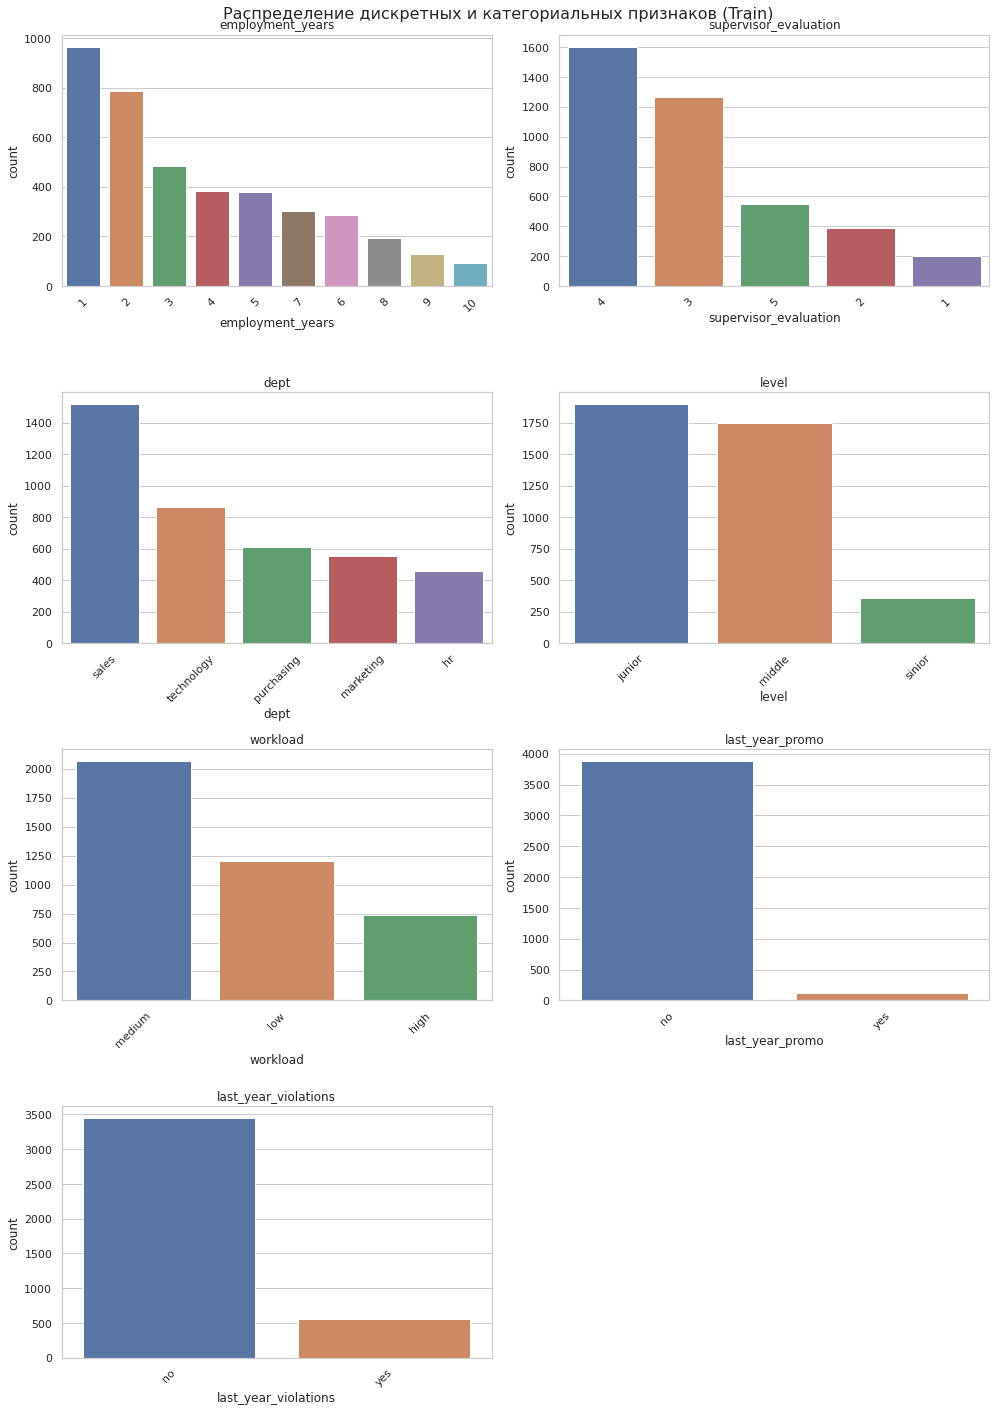

In [20]:
# Тренировочная выборка
explore_dataframe(train_df, "Train")

In [21]:
# Исправляем опечатку в значении 'sinior' -> 'senior'
train_df['level'] = train_df['level'].str.strip().str.lower().replace('sinior', 'senior')
train_df['level'].unique()

array(['junior', 'middle', 'senior'], dtype=object)

В тренировочном датасете представлено 3994 записи после предобработки. Целевой признак `job_satisfaction_rate` распределён относительно равномерно, с пиковой плотностью в диапазоне 0.6-0.7. Среднее значение составляет 0.53.

Признак `salary` имеет правостороннее смещённое распределение с медианой около 30 000 и максимумом почти 100 000. Большинство сотрудников зарабатывают в пределах до 50 000.

Среди категориальных признаков наибольшее представительство имеют:
- `dept`: sales;
- `level`: junior и middle примерно поровну, senior встречается редко;
- `workload`: преобладает medium;
- `last_year_promo`: подавляющее большинство сотрудников не получали повышение;
- `last_year_violations`: также в основном отсутствуют.

Признак `employment_years` показывает спад с увеличением стажа: больше всего сотрудников со стажем 1-2 года. Оценка руководителя (`supervisor_evaluation`) чаще всего равна 4 или 3.

--- Анализ таблицы: Test ---

Числовые признаки:



,count,mean,std,min,25%,50%,75%,max
employment_years,2000.0,3.66650,2.537222,1.00,1.00,3.00,6.00,10.0
supervisor_evaluation,2000.0,3.52650,0.996892,1.00,3.00,4.00,4.00,5.0
salary,2000.0,34066.80000,15398.436729,12000.00,22800.00,30000.00,43200.00,96000.0
job_satisfaction_rate,2000.0,0.54878,0.220110,0.03,0.38,0.58,0.72,1.0



Категориальные признаки:



,Признак,Уникальных значений,Мода
0,dept,6,sales
1,level,3,junior
2,workload,4,medium
3,last_year_promo,2,no
4,last_year_violations,2,no


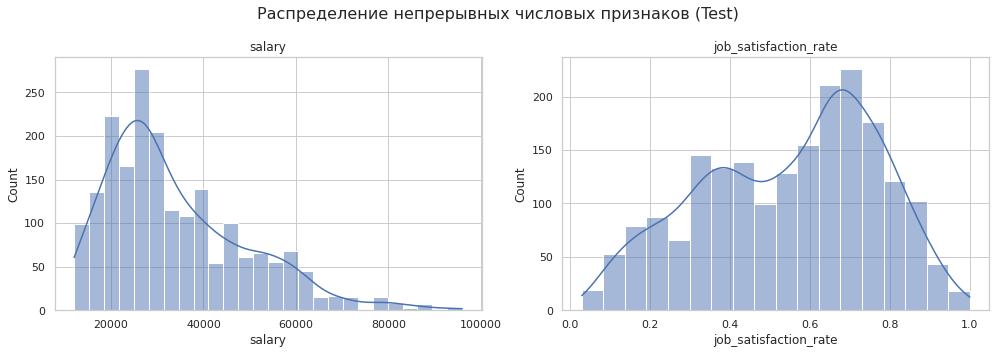

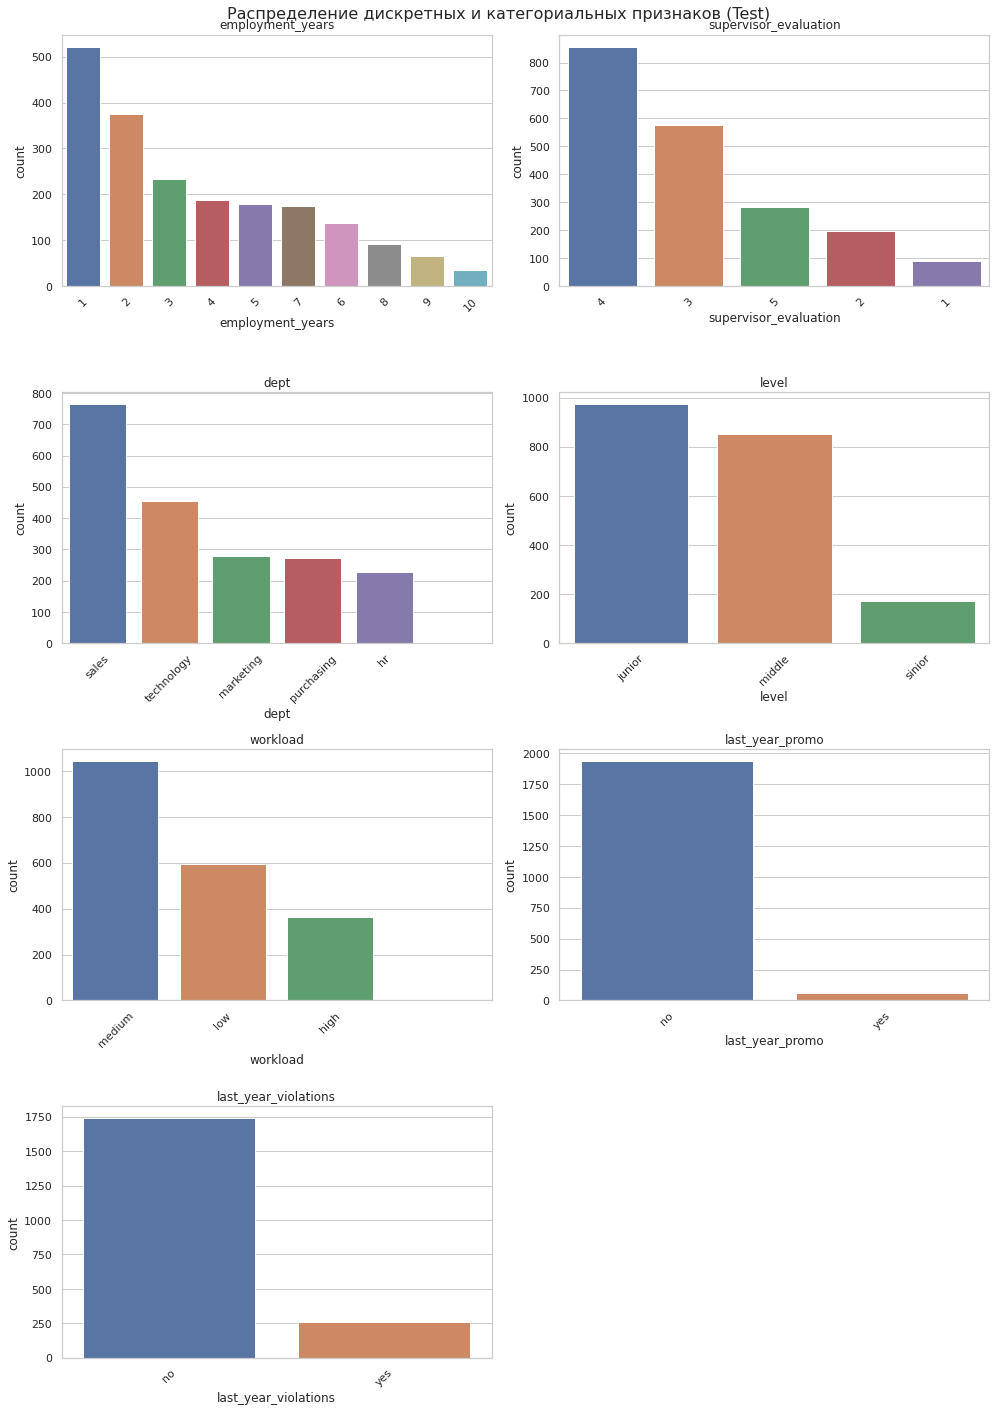

In [22]:
# Тестовая выборка
explore_dataframe(test_full_df, "Test")

In [23]:
# Исправляем опечатку в значении 'sinior' -> 'senior'
test_full_df['level'] = test_full_df['level'].str.strip().str.lower().replace('sinior', 'senior')
test_full_df['level'].unique()

array(['junior', 'middle', 'senior'], dtype=object)

In [24]:
# Проверим наличие пустых строк в категориальных признаках
for col in ['dept', 'workload']:
    mask = (test_full_df[col].astype(str).str.strip() == "")
    if mask.any():
        print(f"Аномалии в столбце {col}:")
        display(test_full_df[mask])

Аномалии в столбце dept:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1699,822186,,middle,medium,3,no,no,4,38400,0.64


Аномалии в столбце workload:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
15,590867,marketing,junior,,4,no,no,4,28800,0.79


In [25]:
# Заменяем "" на моду по каждому из указанных столбцов
for col in ['dept', 'workload']:
    mode_val = test_full_df.loc[test_full_df[col] != " ", col].mode()[0]
    test_full_df[col] = test_full_df[col].replace(" ", mode_val)

In [26]:
# Проверим наличие пустых строк в категориальных признаках
for col in ['dept', 'workload']:
    mask = (test_full_df[col].astype(str).str.strip() == "")
    if mask.any():
        print(f"Аномалии в столбце {col}:")
        display(test_full_df[mask])

Тестовая выборка содержит 2000 записей. Распределение целевого признака `job_satisfaction_rate` схоже с обучающей выборкой: значения также равномерно распределены, но среднее немного выше (0.55 против 0.53). Распределение зарплат аналогично обучающей выборке - правостороннее, с медианой около 30 000 и максимумом в районе 96 000.

Категориальные признаки демонстрируют ту же структуру, что и в обучении: преобладают отделы `sales` и `technology`, уровни `junior` и `middle`, нагрузка чаще всего `medium`. Значения `last_year_promo` и `last_year_violations` также сильно несбалансированы, в пользу категории `no`.

Статистики числовых признаков практически идентичны обучающей выборке, что подтверждает сопоставимость распределений между выборками и корректность дальнейшей оценки моделей.

#### Оценка корреляций

Оценку корреляций в первую очередь имеет смысл проводить на тренировочной выборке, так как именно она используется для обучения моделей и выявления значимых зависимостей между признаками и целевым значением.

In [27]:
# Тепловая карта корреляций между числовыми признаками
def plot_numeric_correlations(df, title='Корреляция числовых признаков'):
    df = df.drop(columns=['id'], errors='ignore')
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    corr = df[numeric_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [28]:
# Φ-корреляция с помощью библиотеки phik
def plot_phik_correlations(df, title='Φ-корреляция признаков'):
    df = df.drop(columns=['id'], errors='ignore')
    # Определим интервальные (числовые) признаки
    interval_cols = ['salary', 'job_satisfaction_rate']

    # Вычислим φ-матрицу с указанием интервалов
    phik_corr = df.phik_matrix(interval_cols=interval_cols)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(phik_corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [29]:
# Горизонтальный barplot корреляций с целевым признаком
def plot_target_correlations(df, target_col, method='pearson', title='Связь признаков с целевой переменной'):
    df = df.drop(columns=['id'], errors='ignore')
    if method == 'phik':
        interval_cols = ['salary', 'job_satisfaction_rate']
        phik_corr = df.phik_matrix(interval_cols=interval_cols)
        corrs = phik_corr[target_col].drop(target_col).sort_values(ascending=False)
    else:
        numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
        corrs = df[numeric_cols].corr()[target_col].drop(target_col).sort_values(ascending=False)

    plt.figure(figsize=(8, len(corrs) * 0.5))
    sns.barplot(x=corrs.values, y=corrs.index, palette="coolwarm")
    plt.xlabel('Коэффициент корреляции')
    plt.ylabel('Признаки')
    plt.title(title)
    plt.tight_layout()
    plt.show()

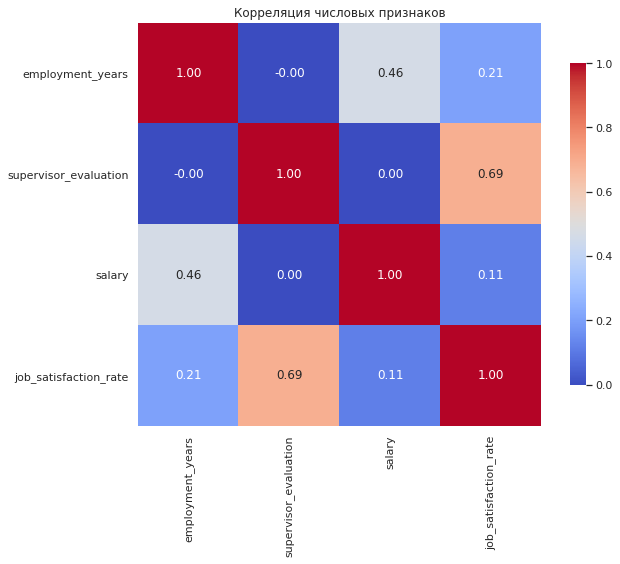

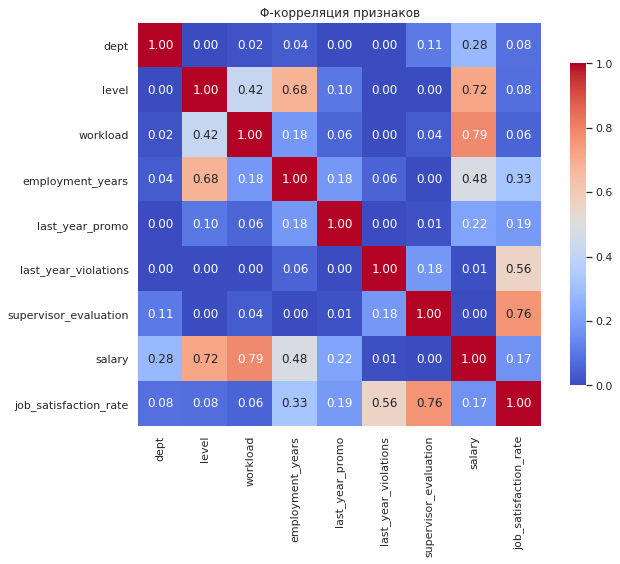

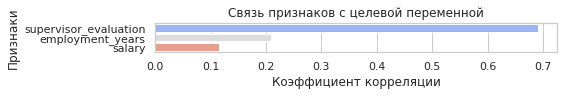

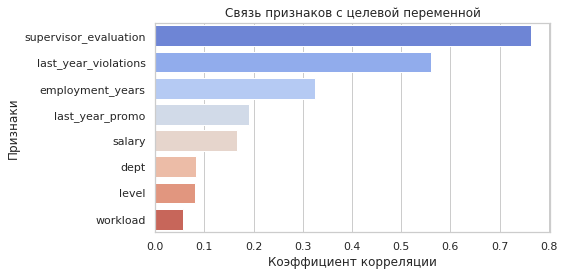

In [30]:
plot_numeric_correlations(train_df)
plot_phik_correlations(train_df)
plot_target_correlations(train_df, target_col='job_satisfaction_rate')
plot_target_correlations(train_df, target_col='job_satisfaction_rate', method='phik')

Корреляционный анализ показал, что признаки в тренировочной выборке не содержат сильной избыточности. Коэффициенты корреляции между числовыми признаками не превышают 0.46 (между `employment_years` и `salary`), что находится в допустимых пределах. Это означает, что признаки дают различную информацию и могут использоваться совместно при обучении моделей без риска мультиколлинеарности.

Наибольшая линейная связь с целевым признаком `job_satisfaction_rate` наблюдается у признака `supervisor_evaluation` (коэффициент Пирсона ≈ 0.69), что логично: высокая оценка руководителя, как правило, отражает более высокую удовлетворённость работой. Незначительная положительная связь также наблюдается у `employment_years` и `salary`.

По результатам φ-корреляции, которая учитывает как числовые, так и категориальные признаки, наиболее сильная связь с целевой переменной у `supervisor_evaluation` (0.76) и `last_year_violations` (0.56), что подтверждает их потенциальную значимость в моделях.

В целом, структура взаимосвязей в данных адекватна: признаки разнообразны по содержанию и ряд из них демонстрирует информативность в отношении целевого признака.

Оценим корреляции на `test`-выборке.

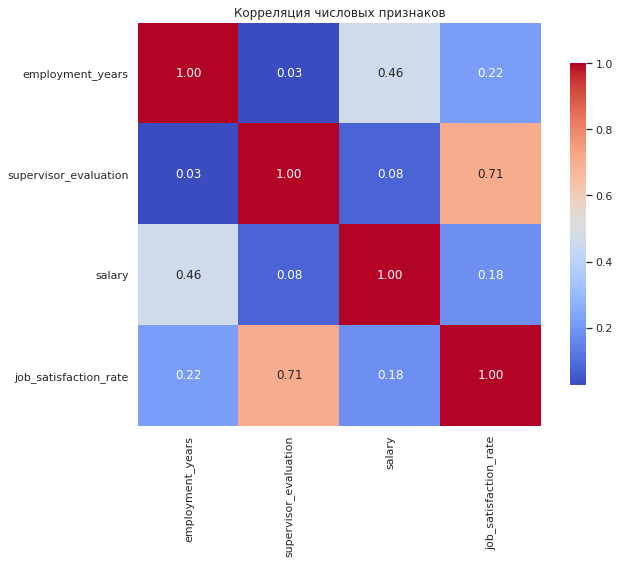

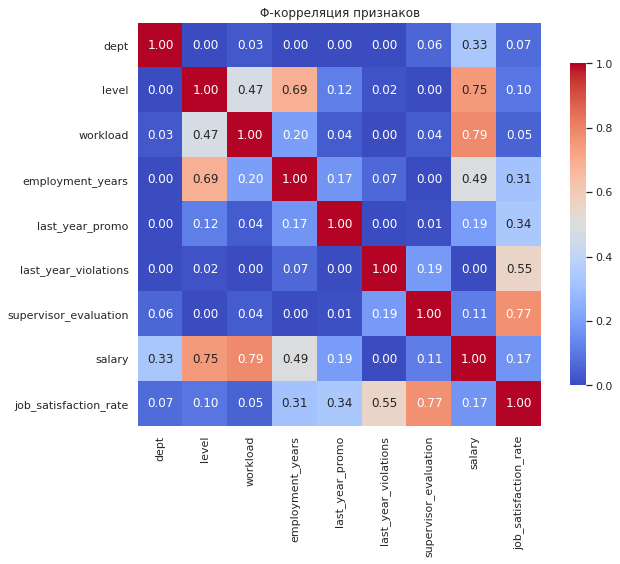

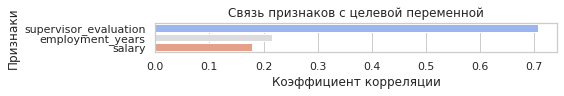

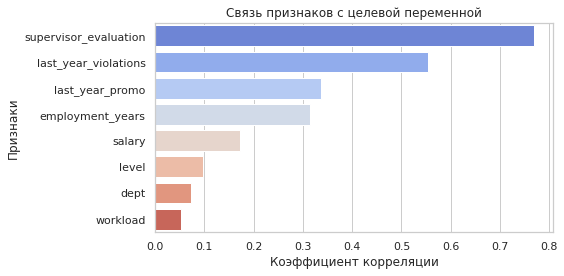

In [31]:
plot_numeric_correlations(test_full_df)
plot_phik_correlations(test_full_df)
plot_target_correlations(test_full_df, target_col='job_satisfaction_rate')
plot_target_correlations(test_full_df, target_col='job_satisfaction_rate', method='phik')

В целом, как и ожидалось, результаты аналогичны `train`-выборке. Таким образом, в данных нет существенных различий в части распределений признаков и что оценка модели, полученная на `test`-выборке, будет корректной.

По результатам исследовательского анализа данные имеют разумное распределение: числовые признаки не содержат аномалий, категориальные сбалансированы в пределах допустимого. Признаки `salary` и `employment_years` имеют правостороннее распределение, наиболее частые значения категориальных признаков - `sales`, `junior`, `medium`, `no` (для `last_year_promo` и `last_year_violations`).

Корреляционный анализ показал отсутствие сильной взаимосвязи между признаками, что позволяет использовать их совместно без риска дублирования информации. Наибольшую связь с целевой переменной продемонстрировали `supervisor_evaluation`, `last_year_violations` и `employment_years`.

С учётом содержательной природы признаков и результатов анализа, подготовку признаков целесообразно реализовать следующим образом:
1. Ordinal Encoding (порядковое кодирование):
- `level` - уровни должности (`junior` < `middle` < `senior`);
- `workload` - уровень нагрузки (`low` < `medium` < `high`);

2. One-Hot Encoding (dummy-кодирование):
- `dept` - номинативный признак без упорядоченности;
- `last_year_promo`, `last_year_violations` - бинарные категориальные признаки, логично применить OHE для согласованности с пайплайном.

3. Масштабирование числовых признаков:
- `supervisor_evaluation` - числовая шкала от 1 до 5, уже представлена в виде int, кодировать не нужно;
- `employment_years` - можно оставить как есть (числовой признак), без кодирования;
- `salary` - непрерывный признак.

### Подготовка данных

Начнём с явного определения признаков и целевого столбца. Поскольку сплит уже выполнен, остаётся просто сформировать `X_train`, `y_train`, `X_test`, `y_test` из `train_df` и `test_full_df`.

In [32]:
# Определяем признаки и целевой столбец
target_col = "job_satisfaction_rate"

# Все признаки, кроме id и целевого
feature_cols = [col for col in train_df.columns if col not in ["id", target_col]]

# Разделение на признаки и целевой признак
X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_test = test_full_df[feature_cols]
y_test = test_full_df[target_col]

Явная группировка признаков.

In [33]:
ohe_features = ['dept', 'last_year_promo', 'last_year_violations']
ord_features = ['level', 'workload']
num_features = ['employment_years', 'supervisor_evaluation', 'salary']

In [34]:
# Порядок категорий для OrdinalEncoder
ordinal_categories = [
    ['junior', 'middle', 'senior'],  # level
    ['low', 'medium', 'high']        # workload
]

Кодировщики и масштабирование.

In [35]:
# OHE-кодирование с устранением дамми-ловушки
ohe_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
])

In [36]:
# Ordinal-кодирование с фиксированным порядком
ord_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ord', OrdinalEncoder(categories=ordinal_categories,
                           handle_unknown='use_encoded_value',
                           unknown_value=-1))
])

# Список масштабировщиков для последующего перебора
scalers = [StandardScaler(), MinMaxScaler()]

# Выбранный скейлер
scaler = StandardScaler()

`ColumnTransformer` и финальный `Pipeline`.

In [37]:
# Общий препроцессор
preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_features),
    ('ord', ord_pipe, ord_features),
    ('num', scaler, num_features)
])

In [38]:
# Финальный пайплайн с моделью-заглушкой
pipe = Pipeline([
    ('missing', CustomMissingHandler()),    # сначала обработка пропусков
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

В рамках этапа подготовки признаков были явно выделены группы признаков по типу обработки: категориальные признаки закодированы с помощью One-Hot и Ordinal Encoding, числовые масштабируются с использованием стандартных скейлеров. Обработка пропущенных значений включена в пайплайн с помощью кастомного трансформера. Финальный пайплайн объединяет все шаги предобработки и далее будет расширен для подбора моделей и гиперпараметров.

### Обучение моделей

В этом разделе будет реализована пользовательская метрика `SMAPE` для оценки качества моделей. Затем будут обучены три регрессионные модели: линейная регрессия, дерево решений и метод опорных векторов. Для моделей будет проведён подбор гиперпараметров с использованием `GridSearchCV` и кросс-валидации. В сетке параметров дополнительно протестируются два варианта масштабирования признаков - `StandardScaler` и `MinMaxScaler`. По результатам кросс-валидации будет выбрана лучшая модель, которая далее будет протестирована на тестовой выборке. Основной метрикой качества при отборе и сравнении моделей будет выступать `SMAPE`.

**SMAPE** (Symmetric Mean Absolute Percentage Error) - симметричная средняя абсолютная процентная ошибка. Это метрика, которая измеряет отклонение между предсказанными и фактическими значениями в процентах и является нормированной альтернативой MAE.

Формула:

$$
\text{SMAPE} = \frac{100}{n} \sum_{i=1}^{n} \frac{|\hat{y}_i - y_i|}{(|y_i| + |\hat{y}_i|)/2}
$$

где:
- $ y_i $ - фактическое значение,
- $ \hat{y}_i $ - предсказанное значение,
- $ n $ - количество наблюдений.

Метрика принимает значения от 0 до 100, где меньшие значения соответствуют более высокой точности модели. Она устойчива к масштабам и симметрична: одинаково наказывает переоценку и недооценку.

**Критерий успеха:** SMAPE ≤ 15 на тестовой выборке.

In [39]:
# SMAPE как функция
def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred)
    smape_score = np.mean(np.divide(diff, denominator, out=np.zeros_like(diff), where=denominator != 0)) * 100
    return smape_score

# make_scorer для GridSearchCV (меньше — лучше)
smape_scorer = make_scorer(smape, greater_is_better=False)

Определим всю сетку с методами с гиперпараметрами.

In [40]:
param_grid = [
    # Линейные модели
    {
        'model': [Ridge(random_state=RANDOM_STATE), Lasso(random_state=RANDOM_STATE)],
        'model__alpha': [0.01, 0.1, 1.0, 10.0],
        'preprocessor__num': scalers
    },
    
    # Decision Tree
    {
        'model': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'model__max_depth': [3, 5, 7, 10, None],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'preprocessor__num': scalers
    },

    # SVR
    {
        'model': [SVR()],
        'model__kernel': ['linear', 'rbf', 'poly'],
        'model__C': [0.1, 1, 10],
        'model__epsilon': [0.01, 0.1, 0.2],
        'model__degree': [2, 3],  # применимо только к 'poly'
        'preprocessor__num': scalers
    }
]

Для подбора наилучшей модели будет использован `GridSearchCV` с 5-кратной кросс-валидацией. В рамках одной общей сетки параметров будут протестированы три модели: линейные регрессоры (`Ridge` и `Lasso`), дерево решений (`DecisionTreeRegressor`) и метод опорных векторов (`SVR`). Для каждой модели подбираются соответствующие гиперпараметры. Дополнительно перебираются два варианта масштабирования числовых признаков: `StandardScaler` и `MinMaxScaler`. В качестве метрики используется пользовательская реализация SMAPE. Лучшие параметры определяются по среднему значению метрики на валидационных фолдах.

In [41]:
# Поиск по сетке
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=smape_scorer,
    cv=5,
    n_jobs=-1,
)

# Обучение
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('missing', CustomMissingHandler()),
                                       ('preprocessor',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['dept',
                                                                          'last_year_promo',
                                                                          'last_year_violations']),
                                                                        ('ord',
                                                                         Pipeline...
                          'model__min_samples_split': [2, 5, 10],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler()]},
                         {'model': [SVR()], 'model__C': [0.1, 1, 10],
                          'model__degree': [2, 3],
                          'model__epsilon': [0.01, 0.1, 0.2],
                          'model__kernel': ['linear', 'rbf', 'poly'],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler()]}],
             scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

Посмотрим на лучшую модель и результаты CV.

In [42]:
print("Лучшая модель:", grid.best_estimator_)
print("Лучшие параметры:", grid.best_params_)
print("Лучшая метрика (SMAPE):", -grid.best_score_)  # знак минус, так как метрика отрицательная

Лучшая модель: Pipeline(steps=[('missing', CustomMissingHandler()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(ste

Посмотрим примеры результатов других моделей. 

In [43]:
# Преобразуем в DataFrame
cv_results = pd.DataFrame(grid.cv_results_)

# Оставим только интересующие колонки
results = cv_results[
    ['mean_test_score', 'rank_test_score', 'param_model', 'param_preprocessor__num']
].copy()

# Отсортируем по качеству
results = results.sort_values(by='mean_test_score', ascending=False)

# Преобразуем SMAPE обратно в положительное значение для читаемости
results['SMAPE'] = -results['mean_test_score']

# Выводим таблицу
display(results[['rank_test_score', 'param_model', 'param_preprocessor__num', 'SMAPE']])

,rank_test_score,param_model,param_preprocessor__num,SMAPE
162,1,SVR(),StandardScaler(),14.164022
144,1,SVR(),StandardScaler(),14.164022
97,3,DecisionTreeRegressor(random_state=42),MinMaxScaler(),14.612073
96,4,DecisionTreeRegressor(random_state=42),StandardScaler(),14.626732
99,5,DecisionTreeRegressor(random_state=42),MinMaxScaler(),14.663127
...,...,...,...,...
13,210,Lasso(random_state=42),MinMaxScaler(),39.963243
11,210,Lasso(random_state=42),MinMaxScaler(),39.963243
12,210,Lasso(random_state=42),StandardScaler(),39.963243
14,210,Lasso(random_state=42),StandardScaler(),39.963243


Протестируем модель на тестовой выборке.

In [44]:
# Предсказание на тесте
y_pred = grid.best_estimator_.predict(X_test)

# Вычисление метрик
smape_test = smape(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Вывод
print(f"SMAPE (test): {smape_test:.2f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")

SMAPE (test): 13.44
MAE: 0.0577
MSE: 0.0051
R²: 0.8939


На этапе обучения были протестированы три регрессионные модели: линейные (`Ridge`, `Lasso`), дерево решений (`DecisionTreeRegressor`) и метод опорных векторов (`SVR`). Подбор гиперпараметров и способов масштабирования признаков выполнялся с помощью `GridSearchCV` с 5-кратной кросс-валидацией. В качестве основной метрики использовалась `SMAPE`.

Лучший результат показала модель `SVR` с ядром `rbf`, параметрами `C=1`, `epsilon=0.01` и масштабированием признаков с помощью `StandardScaler`. Её средний `SMAPE` по кросс-валидации составил 14.16, а на тестовой выборке - 13.44, что удовлетворяет заданному критерию (`SMAPE ≤ 15`). Также были опробованы деревья решений, которые показали близкие результаты (`SMAPE ~14.6`), а вот линейные модели, особенно `Lasso`, показали значительно более высокие значения `SMAPE` - до 40, что указывает на недостаточную гибкость при аппроксимации целевой зависимости.

Таким образом, модель `SVR` продемонстрировала наилучшее качество на обоих этапах - как на кросс-валидации, так и на тестовой выборке.

### Выводы по задаче 1

В рамках первой задачи была построена модель для прогнозирования уровня удовлетворённости сотрудников работой на основе предоставленных признаков. На этапе предобработки были выявлены и обработаны пропущенные значения: строки с отсутствующим `dept` были удалены, а пропуски в `level` заполнены на основе медианной зарплаты. Также были проверены и исключены потенциальные ошибки в данных, включая опечатки.

Для построения признакового пространства использовались комбинации кодировщиков: категориальные признаки обрабатывались с помощью One-Hot и Ordinal Encoding, числовые масштабировались двумя разными скейлерами. Обработка пропусков и подготовка признаков были встроены в общий `Pipeline`, что обеспечило корректную трансформацию как на этапе обучения, так и на тестировании.

Была реализована пользовательская метрика `SMAPE`, которая выступила основным критерием качества. Сравнение трёх моделей - линейной регрессии (`Ridge`, `Lasso`), дерева решений и метода опорных векторов (`SVR`) - позволило определить наилучшее решение. По результатам кросс-валидации и тестирования наилучшее качество показала модель `SVR` с ядром `rbf` и масштабированием `StandardScaler`. Среднее значение `SMAPE` по кросс-валидации составило 14.16, а на тестовой выборке - 13.44, что соответствует критерию успешности (`SMAPE ≤ 15`).

Таким образом, задача прогнозирования удовлетворённости сотрудников решена с высокой точностью. Построенный пайплайн универсален и может быть использован для обработки новых данных без изменения логики предобработки.

## Задача 2: предсказание увольнения сотрудника из компании

Для этой задачи мы будем использовать те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это `quit` — увольнение сотрудника из компании.

### Загрузка и изучение данных

Загрузим датасеты, сохраним их в датафреймы и изучим общую информацию о данных.

In [45]:
# Пути к файлам
path_train_quit = "/datasets/train_quit.csv"
path_test_features = "/datasets/test_features.csv"  # тот же, что и раньше
path_test_target_quit = "/datasets/test_target_quit.csv"

# Загрузка
train_quit = load_and_inspect_csv(path_train_quit)

Файл успешно загружен: /datasets/train_quit.csv


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
555,862161,sales,middle,high,6,yes,no,4,52800,no
3491,255595,sales,middle,medium,4,no,no,4,38400,no
527,205797,sales,junior,high,1,no,no,4,34800,no
3925,515388,sales,junior,low,2,no,no,4,15600,no
2989,590294,technology,junior,low,1,no,no,4,15600,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


Обучающая выборка `train_quit.csv` содержит 4000 записей и 10 столбцов, включая целевой признак `quit`, отражающий факт увольнения сотрудника (`yes` / `no`). Все значения непустые. Структура признаков полностью совпадает с предыдущей задачей: имеются категориальные (например, `dept`, `level`, `workload`), числовые (`employment_years`, `salary`) и бинарные (`last_year_promo`, `last_year_violations`) признаки. Целевой столбец представлен в виде категориального признака и подлежит преобразованию в числовой формат перед обучением модели.

In [46]:
# Загрузка
test_features = load_and_inspect_csv(path_test_features)

Файл успешно загружен: /datasets/test_features.csv


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1860,112724,marketing,middle,low,5,no,yes,3,25200
353,509518,sales,middle,low,3,no,no,4,19200
1333,687861,purchasing,middle,high,7,no,no,5,55200
905,616289,sales,middle,medium,4,no,no,4,38400
1289,355227,technology,junior,medium,1,no,no,4,31200


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


С этим датасетом мы уже знакомы.

In [47]:
# Загрузка
test_target_quit = load_and_inspect_csv(path_test_target_quit)

Файл успешно загружен: /datasets/test_target_quit.csv


,id,quit
1860,268896,no
353,384590,no
1333,530409,no
905,753246,no
1289,603262,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Файл содержит 2000 строк и 2 столбца: `id` и `quit`, где `quit` - целевой признак для тестовой выборки, отражающий факт увольнения сотрудника (`yes` / `no`). Пропусков нет, тип данных признака - строковый, что требует дальнейшего преобразования в числовой формат для задачи классификации. Структура соответствует аналогичному тренировочному признаку.

Таким образом, мы загрузили все данные и изучили общую информацию о них.

### Предобработка данных

Проверим явно пропуски и дубли в датафреймах.

In [48]:
# Проверка пропусков
print("Проверка пропусков:")
analyze_missing_values(train_quit)
analyze_missing_values(test_features)
analyze_missing_values(test_target_quit)

Проверка пропусков:
Пропущенные значения отсутствуют.
Число пропусков по столбцам:


dept     2
level    1
dtype: int64


Строки с пропущенными значениями:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
312,471990,sales,NaN,low,1,no,no,3,12000
1196,832342,NaN,junior,medium,1,no,no,4,28800


Пропущенные значения отсутствуют.


В уже известном нам датафрейме те же пропуски, обработаем их нашим готовым и обученным трансформером.

In [49]:
# Применяем ранее обученный трансформер к тестовым признакам
test_features = missing_handler.transform(test_features)

analyze_missing_values(test_features)

Пропущенные значения отсутствуют.


In [50]:
# Проверка дубликатов
print("\nПроверка дубликатов:")
analyze_duplicates(train_quit)
analyze_duplicates(test_features)
analyze_duplicates(test_target_quit)


Проверка дубликатов:
Дубликаты отсутствуют.
Дубликаты отсутствуют.
Дубликаты отсутствуют.


Теперь аналогично задаче 1 сделаем объединение тестовых признаков с целевым столбцом по `id`.

In [51]:
# Объединение test_features с целевым признаком по id
test_full_quit = test_features.merge(test_target_quit, on="id", how="inner")
test_full_quit.info()
analyze_missing_values(test_full_quit)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   2000 non-null   object
 2   level                  2000 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
 9   quit                   2000 non-null   object
dtypes: int64(4), object(6)
memory usage: 171.9+ KB
Пропущенные значения отсутствуют.


Объединение тестовых признаков c целевым прошло успешно.

Предобработка выполнена аналогично задаче 1.

### Исследовательский анализ данных

#### Распределения признаков

Проведем EDA - исследуем все признаки и сделаем выводы о том, как их нужно подготовить.

--- Анализ таблицы: Train ---

Числовые признаки:



,count,mean,std,min,25%,50%,75%,max
employment_years,4000.0,3.70150,2.541852,1.0,2.0,3.0,6.0,10.0
supervisor_evaluation,4000.0,3.47475,1.004049,1.0,3.0,4.0,4.0,5.0
salary,4000.0,33805.80000,15152.415163,12000.0,22800.0,30000.0,43200.0,96000.0



Категориальные признаки:



,Признак,Уникальных значений,Мода
0,dept,5,sales
1,level,3,junior
2,workload,3,medium
3,last_year_promo,2,no
4,last_year_violations,2,no
5,quit,2,no


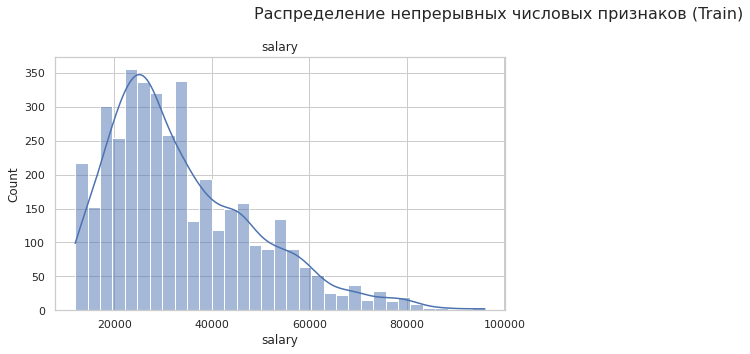

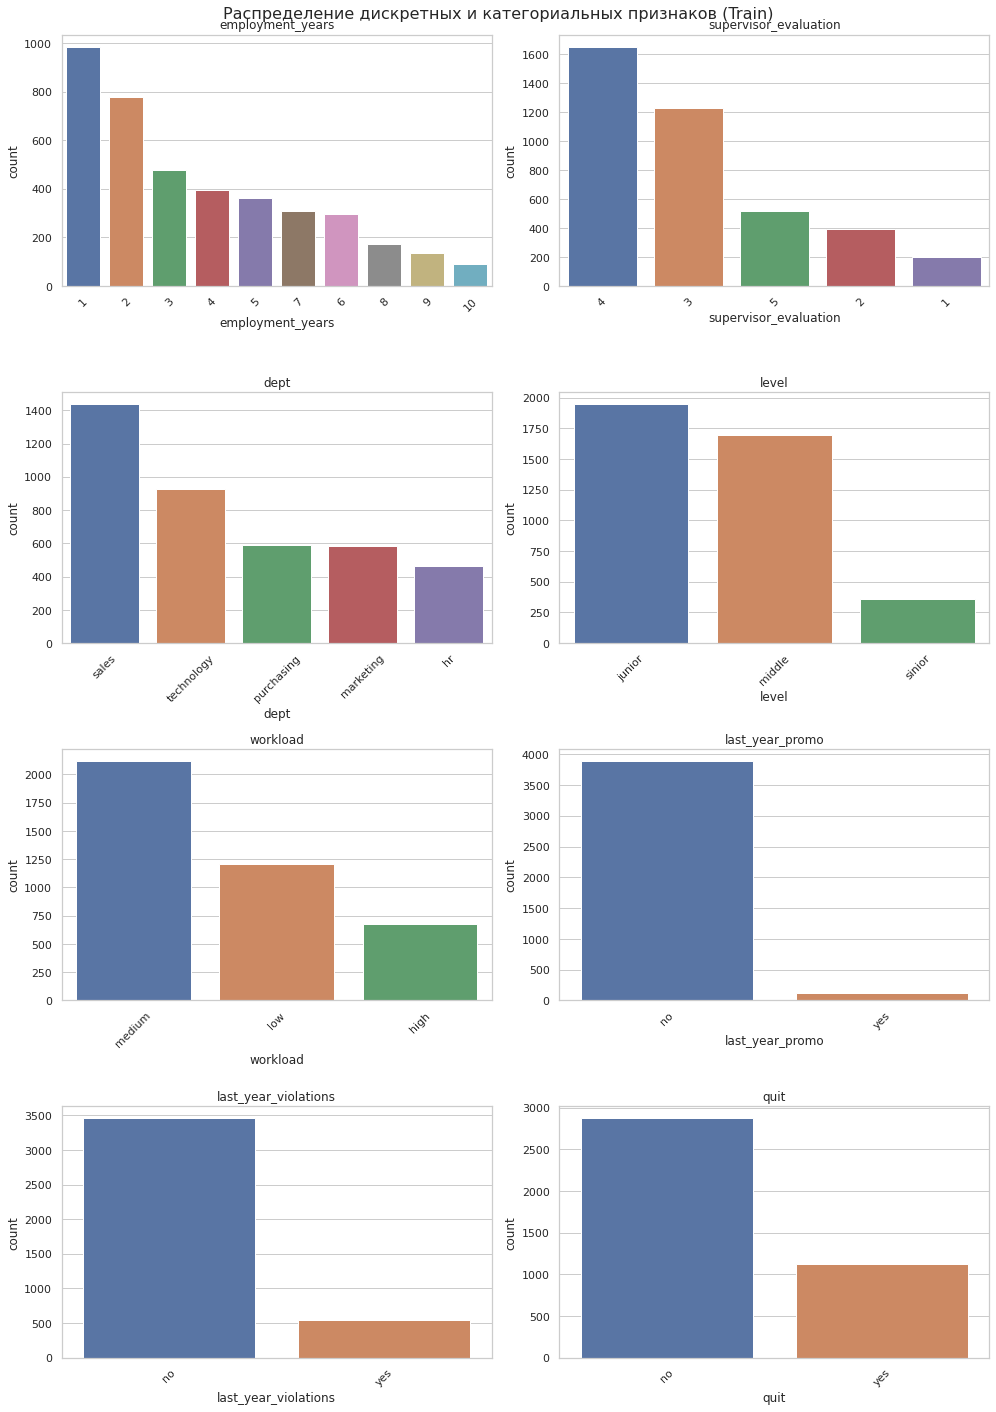

In [52]:
# Тренировочная выборка
explore_dataframe(train_quit, "Train")

In [53]:
# Исправляем опечатку в значении 'sinior' -> 'senior'
train_quit['level'] = train_quit['level'].str.strip().str.lower().replace('sinior', 'senior')
train_quit['level'].unique()

array(['middle', 'junior', 'senior'], dtype=object)

Распределения признаков в обучающей выборке для второй задачи в целом совпадают с данными из первой задачи: типы и характеристики признаков идентичны, отличия касаются только целевого признака. Теперь в качестве целевой переменной выступает бинарный признак `quit`, отражающий факт увольнения сотрудника. Распределение классов дисбалансировано: большинство сотрудников остались в компании (`no`), меньшая часть - уволились (`yes`). Это следует учитывать при выборе модели и метрики качества.

--- Анализ таблицы: Test ---

Числовые признаки:



,count,mean,std,min,25%,50%,75%,max
employment_years,2000.0,3.6665,2.537222,1.0,1.0,3.0,6.0,10.0
supervisor_evaluation,2000.0,3.5265,0.996892,1.0,3.0,4.0,4.0,5.0
salary,2000.0,34066.8000,15398.436729,12000.0,22800.0,30000.0,43200.0,96000.0



Категориальные признаки:



,Признак,Уникальных значений,Мода
0,dept,6,sales
1,level,3,junior
2,workload,4,medium
3,last_year_promo,2,no
4,last_year_violations,2,no
5,quit,2,no


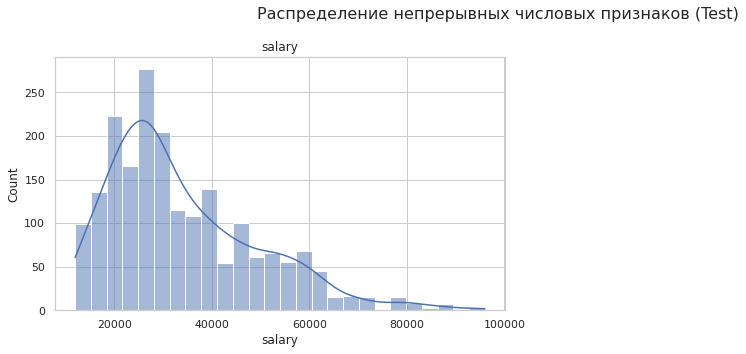

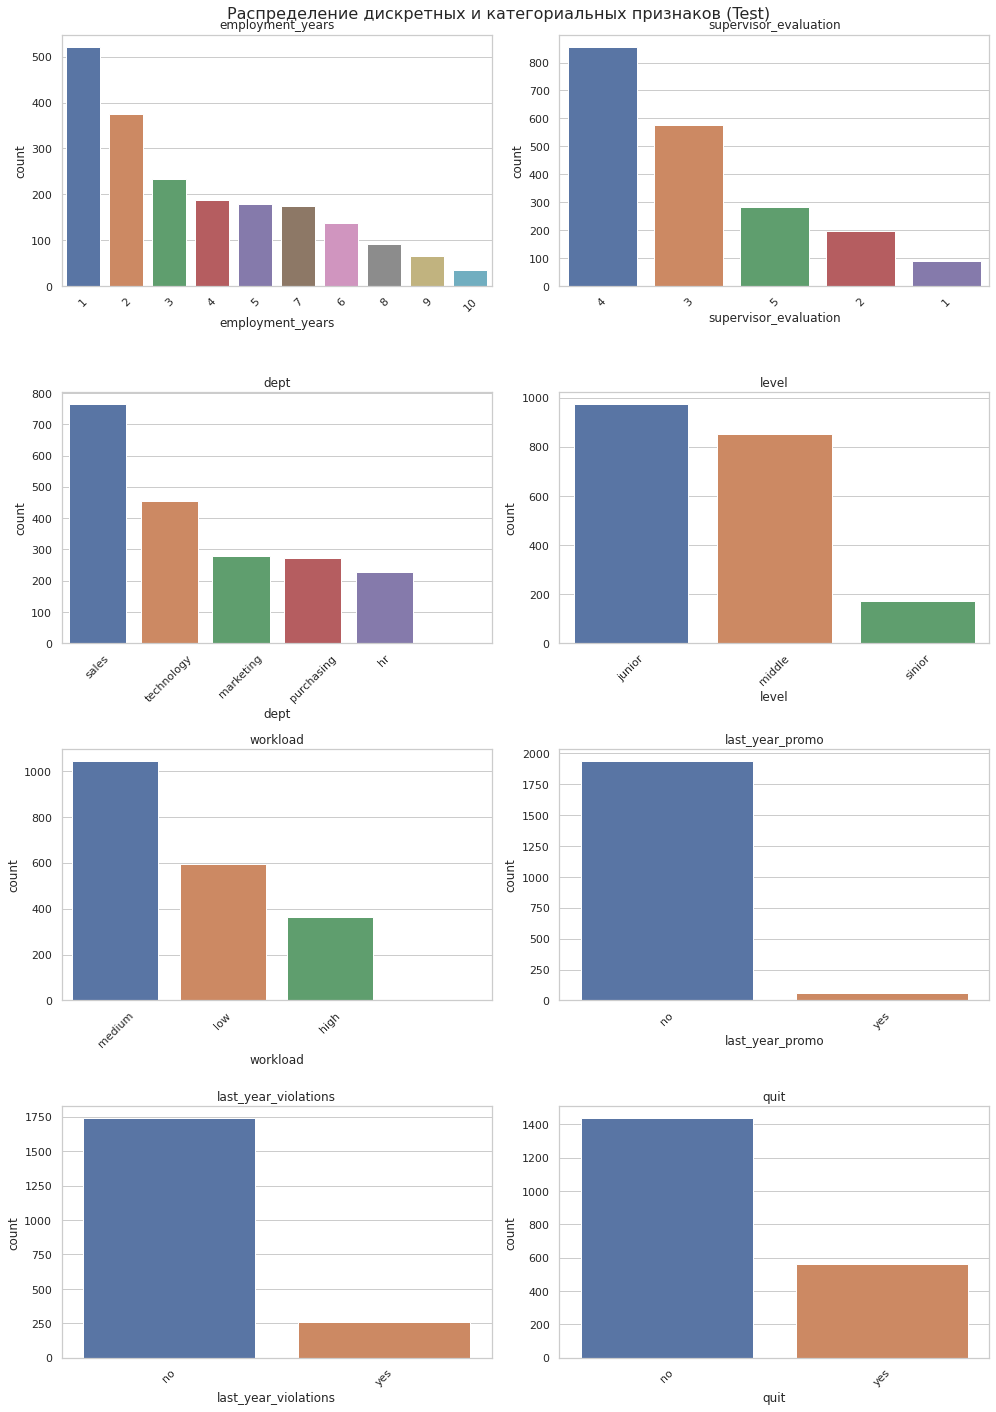

In [54]:
# Тестовая выборка
explore_dataframe(test_full_quit, "Test")

In [55]:
# Исправляем опечатку в значении 'sinior' -> 'senior'
test_full_quit['level'] = test_full_quit['level'].str.strip().str.lower().replace('sinior', 'senior')
test_full_quit['level'].unique()

array(['junior', 'middle', 'senior'], dtype=object)

In [56]:
# Проверим наличие пустых строк в категориальных признаках
for col in ['dept', 'workload']:
    mask = (test_full_quit[col].astype(str).str.strip() == "")
    if mask.any():
        print(f"Аномалии в столбце {col}:")
        display(test_full_quit[mask])

Аномалии в столбце dept:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
1699,822186,,middle,medium,3,no,no,4,38400,no


Аномалии в столбце workload:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
15,590867,marketing,junior,,4,no,no,4,28800,no


In [57]:
# Заменяем "" на моду по каждому из указанных столбцов
for col in ['dept', 'workload']:
    mode_val = test_full_quit.loc[test_full_quit[col] != " ", col].mode()[0]
    test_full_quit[col] = test_full_quit[col].replace(" ", mode_val)

In [58]:
# Проверим наличие пустых строк в категориальных признаках
for col in ['dept', 'workload']:
    mask = (test_full_quit[col].astype(str).str.strip() == "")
    if mask.any():
        print(f"Аномалии в столбце {col}:")
        display(test_full_quit[mask])

Распределения признаков в тестовой выборке аналогичны обучающей и также соответствуют предыдущей задаче. Единственное различие снова касается целевого признака: в тестовой выборке `quit` также является категориальным, но с несколько иным соотношением классов - доля уволившихся выше по сравнению с обучающей выборкой. Это необходимо учитывать при валидации моделей, так как такой дисбаланс может повлиять на обобщающую способность. В остальном структура и статистика признаков стабильна, что позволяет использовать общий пайплайн подготовки.

#### Портрет «уволившегося сотрудника»

Составим портрет «уволившегося сотрудника».

In [59]:
# Кодируем целевой признак через обучаемый трансформер
le = LabelEncoder()
train_quit['quit_encoded'] = le.fit_transform(train_quit['quit'])  # yes = 1

In [60]:
# Частота увольнений по категориям
# Категориальные и дискретные признаки
analyzed_cols = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations',
                 'employment_years', 'supervisor_evaluation']

# Вывод долей увольнений по категориям
for col in analyzed_cols:
    print(f"\nДоля уволившихся по признаку: {col}")
    display(
        train_quit[train_quit['quit_encoded'] == 1][col].value_counts(normalize=True).sort_values(ascending=False)
    )

# Средняя зарплата по статусу увольнения
print("\nСредняя зарплата:")
display(train_quit.groupby('quit')['salary'].mean())

# Дополнительно: средние числовые признаки
print("\nСредние числовые признаки:")
display(train_quit.groupby('quit')[['employment_years', 'supervisor_evaluation']].mean())


Доля уволившихся по признаку: dept


sales         0.360816
technology    0.244681
purchasing    0.147163
marketing     0.144504
hr            0.102837
Name: dept, dtype: float64


Доля уволившихся по признаку: level


junior    0.889184
middle    0.095745
senior    0.015071
Name: level, dtype: float64


Доля уволившихся по признаку: workload


low       0.460106
medium    0.432624
high      0.107270
Name: workload, dtype: float64


Доля уволившихся по признаку: last_year_promo


no     0.999113
yes    0.000887
Name: last_year_promo, dtype: float64


Доля уволившихся по признаку: last_year_violations


no     0.797872
yes    0.202128
Name: last_year_violations, dtype: float64


Доля уволившихся по признаку: employment_years


1     0.531028
2     0.257092
3     0.144504
4     0.023936
5     0.020390
6     0.008865
7     0.006206
8     0.002660
9     0.002660
10    0.002660
Name: employment_years, dtype: float64


Доля уволившихся по признаку: supervisor_evaluation


3    0.463652
4    0.253546
2    0.145390
1    0.084220
5    0.053191
Name: supervisor_evaluation, dtype: float64


Средняя зарплата:


quit
no     37702.228412
yes    23885.106383
Name: salary, dtype: float64


Средние числовые признаки:


,employment_years,supervisor_evaluation
quit,,
no,4.430710,3.643106
yes,1.844858,3.046099


Портрет уволившегося сотрудника формируется на основе различий между группами `quit = yes` и `quit = no`. Ушедшие сотрудники значительно чаще занимали младшие должности (`junior`), имели низкую загруженность и чаще не получали повышения в прошлом году. Также среди них была выше доля сотрудников с зафиксированными нарушениями (`last_year_violations = yes`). В разрезе отделов наиболее высокая доля увольнений наблюдается в `technology` и `sales`.

Уволившиеся сотрудники в среднем проработали в компании меньше двух лет, получали на 14 тыс. меньше зарплаты по сравнению с оставшимися, и имели более низкую оценку от руководства. Эти данные позволяют предположить, что наибольший риск увольнения связан с низкой вовлечённостью и отсутствием карьерного роста на ранних этапах работы.

#### Влияние уровня удовлетворённости на факт увольнения

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверим это утверждение: визуализируем и сравним распределения признака `job_satisfaction_rate` для ушедших и оставшихся сотрудников. Используем данные с обоими целевыми признаками тестовой выборки.

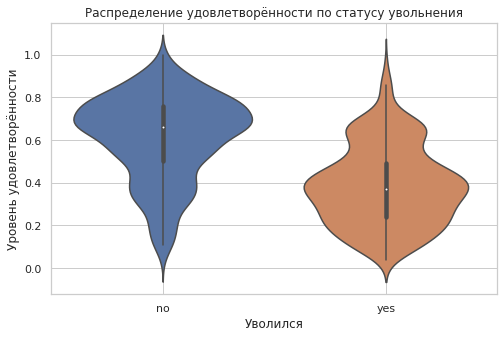

quit
no     0.612040
yes    0.387713
Name: job_satisfaction_rate, dtype: float64


In [61]:
# Объединение по id
test_combined = test_full_df[['id', 'job_satisfaction_rate']].merge(
    test_full_quit[['id', 'quit']], on='id'
)

# Визуализация распределения удовлетворённости по статусу увольнения
plt.figure(figsize=(8, 5))
sns.violinplot(data=test_combined, x='quit', y='job_satisfaction_rate')
plt.title('Распределение удовлетворённости по статусу увольнения')
plt.xlabel('Уволился')
plt.ylabel('Уровень удовлетворённости')
plt.grid(True)
plt.show()

# Средние уровни удовлетворённости
print(test_combined.groupby('quit')['job_satisfaction_rate'].mean())

Визуализация и средние значения подтверждают гипотезу: уровень удовлетворённости сотрудников, уволившихся из компании, значительно ниже по сравнению с теми, кто остался. Среднее значение `job_satisfaction_rate` для уволившихся составляет 0.39, тогда как для оставшихся - 0.61. Распределения этих групп практически не пересекаются, что говорит о сильной зависимости между удовлетворённостью и увольнением. Таким образом, удовлетворённость действительно может служить надёжным предиктором риска оттока.

Анализ распределений показал, что признаки во второй задаче полностью совпадают по структуре с первой задачей. Единственное отличие - это целевой признак: вместо непрерывного уровня удовлетворённости теперь используется бинарный индикатор увольнения. Распределения признаков в обучающей и тестовой выборках схожи, что позволяет использовать общую стратегию подготовки данных.

Был составлен портрет уволившегося сотрудника. Ушедшие из компании сотрудники чаще всего имели младший уровень (`junior`), низкую или среднюю загруженность, не получали повышение и чаще имели нарушения. Средняя зарплата уволившихся сотрудников почти на 14 тыс. ниже, чем у оставшихся, а стаж и оценка от руководства также заметно ниже. Это может указывать на отсутствие развития, вовлечённости и системной поддержки со стороны компании.

Отдельный анализ подтвердил значимую связь между удовлетворённостью и увольнением. Средний уровень удовлетворённости у уволившихся сотрудников составил 0.39 против 0.61 у тех, кто остался. Это свидетельствует о сильной зависимости между этими признаками и подтверждает гипотезу HR-аналитиков о том, что низкая удовлетворённость повышает риск оттока.

### Добавление нового входного признака

`job_satisfaction_rate` и `quit` действительно связаны, и мы получили необходимое значение метрики в первой задаче. Добавим `job_satisfaction_rate`, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

In [62]:
train_quit.loc[X_train.index, 'job_satisfaction_rate_pred'] = grid.best_estimator_.predict(X_train)

In [63]:
test_full_quit['job_satisfaction_rate_pred'] = grid.best_estimator_.predict(X_test)

Теперь признак добавлен и будет доступен при построении новых `X` для классификации.

### Подготовка данных

Подготовим признаки так же, как и в первой задаче.

In [64]:
# Удаление вспомогательного столбца (был нужен для анализа)
train_quit = train_quit.drop(columns=['quit_encoded'], errors='ignore')

In [65]:
# Целевой признак
target_col = "quit"

# Признаки (исключаем id и целевой столбец)
feature_cols = [col for col in train_quit.columns if col not in ["id", target_col]]

# Разделение обучающих данных
X_train_quit = train_quit[feature_cols]
y_train_quit = train_quit[target_col]

# Разделение тестовых данных
X_test_quit = test_full_quit[feature_cols]
y_test_quit = test_full_quit[target_col]

In [66]:
# Кодирование целевого признака
le = LabelEncoder()
y_train_quit = le.fit_transform(y_train_quit)
y_test_quit = le.transform(y_test_quit)
print(le.classes_)

['no' 'yes']


In [67]:
ohe_features = ['dept', 'last_year_promo', 'last_year_violations']
ord_features = ['level', 'workload']
num_features = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate_pred']

In [68]:
# Порядок категорий для OrdinalEncoder
ordinal_categories = [
    ['junior', 'middle', 'senior'],  # level
    ['low', 'medium', 'high']        # workload
]

In [69]:
# OHE-кодирование с устранением дамми-ловушки
ohe_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
])

# Ordinal-кодирование с фиксированным порядком
ord_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ord', OrdinalEncoder(categories=ordinal_categories,
                           handle_unknown='use_encoded_value',
                           unknown_value=-1))
])

# Список масштабировщиков для последующего перебора
scalers = [StandardScaler(), MinMaxScaler()]

# Выбранный скейлер
scaler = StandardScaler()

# Логистическая регрессия как модель по умолчанию
model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)

In [70]:
# Общий препроцессор
preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_features),
    ('ord', ord_pipe, ord_features),
    ('num', scaler, num_features)
])

Добавим сэмплер, так как в задаче есть дисбаланс.

In [71]:
# Список сэмплеров для перебора
samplers = [None, SMOTE(random_state=RANDOM_STATE)]

In [72]:
# Итоговый пайплайн
pipe = ImbPipeline([
    ('missing', CustomMissingHandler()),
    ('preprocessor', preprocessor),
    ('sampler', SMOTE(random_state=RANDOM_STATE)),  # будет заменяться в param_grid
    ('model', model)
])

Таким образом, мы собрали пайплайн аналогично задаче 1, но для классификации с добавлением сэмплера и кодирование таргета.

### Обучение модели

В рамках задачи классификации было решено обучить четыре модели: логистическую регрессию, дерево решений, метод опорных векторов и классификатор на основе k ближайших соседей. Для всех моделей проводится подбор гиперпараметров, а также тестируются различные варианты масштабирования числовых признаков (`StandardScaler`, `MinMaxScaler`) и способы балансировки классов (`None`, `SMOTE`), поскольку в данных наблюдается дисбаланс.

В качестве основной метрики используется ROC-AUC, так как она устойчиво отражает качество модели при дисбалансе классов и позволяет учитывать не только точность классификации, но и степень уверенности модели в своих решениях.<br>
**Критерием успешности** является значение ROC-AUC не менее 0.91 на тестовой выборке.

Определим всю сетку с методами с гиперпараметрами.

In [73]:
param_grid = [

    # Logistic Regression
    {
        'model': [LogisticRegression(solver='liblinear', random_state=RANDOM_STATE)],
        'model__penalty': ['l1', 'l2'],
        'model__C': [0.01, 0.1, 1, 10, 100],
        'preprocessor__num': scalers,
        'sampler': samplers
    },

    # Decision Tree
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'model__max_depth': [3, 5, 7, 10, None],
        'model__min_samples_split': [2, 5, 10],
        'model__max_features': ['sqrt', 'log2', None],
        'preprocessor__num': scalers,
        'sampler': samplers
    },

    # KNeighbors
    {
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': [3, 5, 7, 9],
        'model__weights': ['uniform', 'distance'],
        'model__metric': ['minkowski', 'euclidean', 'manhattan'],
        'preprocessor__num': scalers,
        'sampler': samplers
    },

    # SVC
    {
        'model': [SVC(probability=True, random_state=RANDOM_STATE)],
        'model__C': [0.1, 1, 10, 100],
        'model__kernel': ['linear', 'rbf', 'poly'],
        'model__gamma': ['scale', 'auto'],
        'model__degree': [2, 3, 4],
        'preprocessor__num': scalers,
        'sampler': samplers
    }
]

In [74]:
# GridSearch с ROC-AUC
grid = GridSearchCV(
    estimator=pipe,                  # пайплайн с обработкой и моделью
    param_grid=param_grid,          # сетка с моделями, скейлерами, сэмплерами
    scoring='roc_auc',              # основная метрика
    cv=5,
    n_jobs=-1,
)

# Обучение на тренировочной выборке
grid.fit(X_train_quit, y_train_quit)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('missing', CustomMissingHandler()),
                                       ('preprocessor',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['dept',
                                                                          'last_year_promo',
                                                                          'last_year_violations']),
                                                                        ('ord',
                                                                         Pipeline...
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler()],
                          'sampler': [None, SMOTE(random_state=42)]},
                         {'model': [SVC(probability=True, random_state=42)],
                          'model__C': [0.1, 1, 10, 100],
                          'model__degree': [2, 3, 4],
                          'model__gamma': ['scale', 'auto'],
                          'model__kernel': ['linear', 'rbf', 'poly'],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler()],
                          'sampler': [None, SMOTE(random_state=42)]}],
             scoring='roc_auc')

In [75]:
print("Лучшая модель:", grid.best_estimator_)
print("Лучшие параметры:", grid.best_params_)
print("ROC-AUC на кросс-валидации:", grid.best_score_)

Лучшая модель: Pipeline(steps=[('missing', CustomMissingHandler()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(ste

In [76]:
# Преобразуем результаты в DataFrame
cv_results = pd.DataFrame(grid.cv_results_)

# Добавим колонку с положительным значением ROC-AUC
cv_results['roc_auc'] = cv_results['mean_test_score']

# Оставим только нужные колонки
results = cv_results[[
    'rank_test_score',
    'param_model',
    'param_preprocessor__num',
    'param_sampler',
    'roc_auc'
]].sort_values(by='roc_auc', ascending=False)

# Вывод
display(results)

,rank_test_score,param_model,param_preprocessor__num,param_sampler,roc_auc
104,1,DecisionTreeClassifier(random_state=42),StandardScaler(),None,0.927046
106,1,DecisionTreeClassifier(random_state=42),MinMaxScaler(),None,0.927046
108,3,DecisionTreeClassifier(random_state=42),StandardScaler(),None,0.926915
110,3,DecisionTreeClassifier(random_state=42),MinMaxScaler(),None,0.926915
102,5,DecisionTreeClassifier(random_state=42),MinMaxScaler(),None,0.926574
...,...,...,...,...,...
184,599,DecisionTreeClassifier(random_state=42),StandardScaler(),None,0.817876
208,601,DecisionTreeClassifier(random_state=42),StandardScaler(),None,0.817408
198,602,DecisionTreeClassifier(random_state=42),MinMaxScaler(),None,0.817353
186,602,DecisionTreeClassifier(random_state=42),MinMaxScaler(),None,0.817353


В рамках кросс-валидации было протестировано четыре модели: логистическая регрессия, дерево решений, метод опорных векторов (SVC) и k-ближайших соседей. Для каждой модели выполнен перебор гиперпараметров, масштабировщиков и стратегий балансировки классов. Лучший результат показала модель дерева решений без сэмплера при глубине 5: ROC-AUC = 0.927 на кросс-валидации. Это значение превышает целевой порог в 0.91, установленный в задании, и говорит о высоком качестве классификации.

Проверим лучшую модель на тестовой выборке.

ROC-AUC: 0.91

Отчёт по классам:
              precision    recall  f1-score   support

 не уволился     0.9207    0.9220    0.9214      1436
    уволился     0.8007    0.7979    0.7993       564

    accuracy                         0.8870      2000
   macro avg     0.8607    0.8599    0.8603      2000
weighted avg     0.8869    0.8870    0.8869      2000



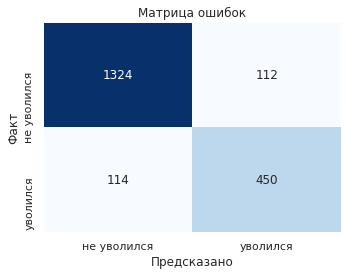

In [77]:
# Предсказания
y_pred = grid.best_estimator_.predict(X_test_quit)
y_proba = grid.best_estimator_.predict_proba(X_test_quit)[:, 1]

# ROC-AUC как основная метрика
roc_auc = roc_auc_score(y_test_quit, y_proba)
print(f"ROC-AUC: {roc_auc:.2f}\n")

# Полный отчёт по классам
print("Отчёт по классам:")
print(classification_report(y_test_quit, y_pred, target_names=['не уволился', 'уволился'], digits=4))

# Матрица ошибок
cm = confusion_matrix(y_test_quit, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['не уволился', 'уволился'],
            yticklabels=['не уволился', 'уволился'])
plt.title("Матрица ошибок")
plt.xlabel("Предсказано")
plt.ylabel("Факт")
plt.tight_layout()
plt.show()

На тестовой выборке достигнуто значение ROC-AUC = 0.91. Оно находится на границе целевого порога (≥ 0.91). При этом на кросс-валидации ROC-AUC уверенно выше критерия (0.927), что подтверждает стабильность и надёжность модели. Учитывая эти обстоятельства, можно считать задачу успешно решённой.

Точность (accuracy) составила 88.7%, то есть в среднем 9 из 10 прогнозов оказываются верными.<br>
Модель особенно хорошо определяет сотрудников, которые не уволятся – их точность составляет 92.1%, а полнота – 92.2%.<br>
Что важно - модель достаточно хорошо выявляет и сотрудников, склонных к увольнению:
- Точность (precision) для класса «уволился» - 80.1%: из всех, кого модель предсказала как ушедших, 80% действительно уволились.
- Полнота (recall) - 79.8%: модель находит почти 8 из 10 реальных увольнений.

Это значит, что модель может эффективно использоваться для прогноза рисков оттока персонала, позволяя вовремя реагировать на потенциальные увольнения.

### Выводы по задаче 2

Во второй задаче была построена модель для предсказания факта увольнения сотрудника. Для решения задачи использовались те же признаки, что и в первой части, с добавлением предсказанного уровня удовлетворённости работой (`job_satisfaction_rate`), полученного из модели регрессии. После обработки данных и учёта дисбаланса классов были протестированы четыре модели: логистическая регрессия, дерево решений, `SVC` и `KNN`. Лучшие результаты показала модель дерева решений без применения сэмплера и с глубиной 5. На кросс-валидации она достигла `ROC-AUC = 0.927`, а на тестовой выборке - 0.91, что соответствует установленному критерию (≥ 0.91). Таким образом, задача успешно решена, а предсказание увольнений на основе внутренних характеристик сотрудника и уровня удовлетворённости можно считать эффективным.

## Общий вывод

В рамках проекта была решена прикладная задача HR-аналитики: построение моделей для предсказания уровня удовлетворённости сотрудников и вероятности их увольнения на основе внутренних характеристик. Целью исследования было создание инструментов, позволяющих компании заранее выявлять сотрудников с риском оттока и снижать финансовые потери, связанные с незапланированными увольнениями.

В ходе работы выполнены следующие этапы:
- Проведена загрузка и первичная проверка данных, выявлены и обработаны пропущенные значения, а также устранены потенциальные дубликаты.
- Проведён исследовательский анализ признаков: изучены распределения переменных, выявлены закономерности и связи с целевыми признаками. Построены визуализации, рассчитаны корреляции.
- В первой задаче (регрессия) была построена модель для предсказания уровня удовлетворённости работой. Использовались линейные и нелинейные алгоритмы, проведён подбор гиперпараметров. Лучший результат показала модель SVR (ядро RBF) с метрикой SMAPE = 13.44 на тесте, что удовлетворяет критерию SMAPE ≤ 15.
- Во второй задаче (классификация) была решена задача предсказания увольнения сотрудника. В качестве дополнительного признака использован предсказанный уровень удовлетворённости из первой модели. Среди четырёх протестированных моделей наилучший результат показало дерево решений. ROC-AUC на кросс-валидации составил 0.927, на тесте - 0.91, что соответствует установленному порогу.
- Построен портрет уволившегося сотрудника: это, как правило, молодой специалист с уровнем junior, низкой или высокой загрузкой, отсутствием недавнего повышения и сравнительно невысокой зарплатой. Уровень удовлетворённости в этой группе также ниже, что подтверждает его прогностическую ценность.

Выводы и рекомендации для бизнеса:
- Уровень удовлетворённости действительно связан с риском увольнения и может использоваться в качестве индикатора для превентивных мер.
- Разработанные модели могут быть внедрены в практику HR-аналитики для мониторинга персонала, оценки рисков оттока и планирования мероприятий по удержанию сотрудников.
- Рекомендуется использовать модель регрессии для периодического предсказания удовлетворённости, а классификационную модель - для выявления групп риска и приоритизации внутренних HR-инициатив.
- Возможным направлением дальнейшего развития может стать включение поведенческих метрик (отпуск, больничные, активность в корпоративных системах) и обратная связь от руководителей.